### Calculating the average token length of Datasets

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset

# dataset_list =['flan_v2', 'oasst1', 'wizardlm', 'dolly', 'stanford_alpaca']
dataset_name='all_train'
root_path = f'model_finetune_cluster/new_train_data/meta-llama/Meta-Llama-3.1-8B-Instruct/{dataset_name}/random_dataset.json'

data = load_dataset('json', data_files =root_path)

prompts = []
completions = []
dialogs = data['train']

for dialog in dialogs['messages']:
    prompts.append(dialog[0]['content']) 
    completions.append(dialog[1]['content'])

#  Meta-Llama tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

prompts_tokenized = tokenizer(prompts, padding=False, truncation=False, return_length=True)
completions_tokenized = tokenizer(completions, padding=False, truncation=False, return_length=True)

prompts_avg_tokens = sum(prompts_tokenized['length']) / len(prompts_tokenized['length'])
completions_avg_tokens = sum(completions_tokenized['length']) / len(completions_tokenized['length'])

prompts_avg_tokens, completions_avg_tokens


In [19]:

conversations = []

for prompt, completion in zip(prompts_tokenized['length'], prompts_tokenized['length']):
    conversations.append(prompt + completion)

count =0
for con in conversations:
    if con > 2048:
        count +=1

count

255

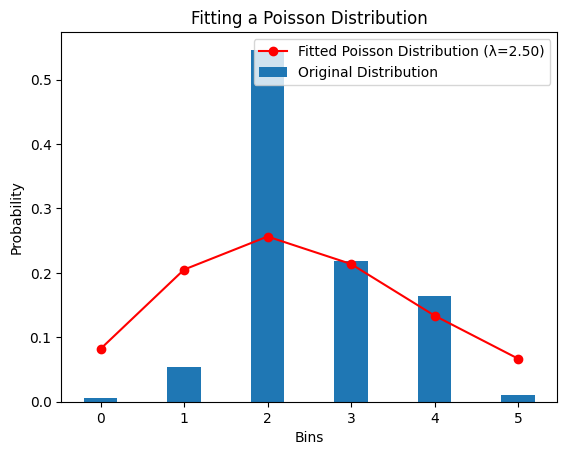

Estimated λ for Poisson Distribution: 2.501


In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 给定的数量分布
distribution = np.array([10, 100, 1000, 400, 300, 20])

# 归一化
relative_frequency = distribution / distribution.sum()

# 模拟区间（bins）的中心值
bins = np.arange(len(distribution))

# 生成样本数据
data = np.random.choice(bins, size=1000, p=relative_frequency)

# 拟合泊松分布的参数λ
lambda_estimate = np.mean(data)

# 使用拟合参数生成泊松分布的PMF
pmf = stats.poisson.pmf(bins, lambda_estimate)

# 比较原始分布和拟合分布
plt.bar(bins, relative_frequency, width=0.4, label='Original Distribution')
plt.plot(bins, pmf, 'ro-', label=f'Fitted Poisson Distribution (λ={lambda_estimate:.2f})')
plt.xlabel('Bins')
plt.ylabel('Probability')
plt.legend()
plt.title('Fitting a Poisson Distribution')
plt.show()

print("Estimated λ for Poisson Distribution:", lambda_estimate)
